In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

cwd = os.getcwd()
print("Current Working Directory:", cwd)
os.chdir(os.path.expanduser("~/clef/animalclef-2025"))
print("Changed Working Directory to:", os.getcwd())

Current Working Directory: /storage/home/hcoda1/2/cmarutha3/clef/animalclef-2025/user/chand2020
Changed Working Directory to: /storage/home/hcoda1/2/cmarutha3/clef/animalclef-2025


In [9]:
from animalclef.spark import get_spark
from pyspark.sql import functions as F, Window
from pyspark.sql import SparkSession
from pathlib import Path
import numpy as np
from animalclef.dataset import split_reid_data, summarize_split
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
spark = get_spark(cores=4, memory="4g")
display(spark)

metadata = spark.read.parquet(f"{Path.home()}/shared/animalclef/data/parquet/metadata")

embeddings = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/dinov2"
)

db_embeddings_features = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/db_embeddings_features.parquet"
)
db_embeddings_metadata = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/db_embeddings_metadata.parquet"
)
query_embeddings_features = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/query_embeddings_features.parquet"
)
query_embeddings_metadata = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/query_embeddings_metadata.parquet"
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/25 17:31:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/25 17:31:33 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [7]:
# Database
df_db_embeddings_metadata = db_embeddings_metadata.toPandas()
df_db_embeddings_features = db_embeddings_features.toPandas()
df_db_embeddings_features["cls"] = df_db_embeddings_features.apply(
    lambda row: np.array(row, dtype=float), axis=1
)
df_db_embeddings_features["image_id"] = df_db_embeddings_metadata["image_id"]

# Query
df_query_embeddings_metadata = query_embeddings_metadata.toPandas()
df_query_embeddings_features = query_embeddings_features.toPandas()
df_query_embeddings_features["cls"] = df_query_embeddings_features.apply(
    lambda row: np.array(row, dtype=float), axis=1
)
df_query_embeddings_features["image_id"] = df_query_embeddings_metadata["image_id"]

In [11]:
spark = SparkSession.builder.appName("PandasToPySpark").getOrCreate()
db_embeddings = spark.createDataFrame(df_db_embeddings_features[["image_id", "cls"]])
query_embeddings = spark.createDataFrame(
    df_query_embeddings_features[["image_id", "cls"]]
)

In [12]:
combined_embeddings = db_embeddings.unionByName(query_embeddings)

df = metadata.join(combined_embeddings, on=["image_id"]).select(
    "image_id",
    "identity",
    "dataset",
    "cls",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
)
df.printSchema()
df.show()

root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cls: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- identity_count: long (nullable = false)



25/04/25 17:49:19 WARN TaskSetManager: Stage 17 contains a task of very large size (120126 KiB). The maximum recommended task size is 1000 KiB.


+--------+------------------+----------+--------------------+--------------+
|image_id|          identity|   dataset|                 cls|identity_count|
+--------+------------------+----------+--------------------+--------------+
|     329|LynxID2025_lynx_04|LynxID2025|[0.75290232896804...|             3|
|     472|LynxID2025_lynx_04|LynxID2025|[0.46819686889648...|             3|
|    3414|LynxID2025_lynx_04|LynxID2025|[0.19465856254100...|             3|
|    2264|LynxID2025_lynx_08|LynxID2025|[0.17942652106285...|             1|
|      17|LynxID2025_lynx_16|LynxID2025|[0.15272599458694...|            36|
|     189|LynxID2025_lynx_16|LynxID2025|[0.46724987030029...|            36|
|     407|LynxID2025_lynx_16|LynxID2025|[0.45012849569320...|            36|
|     686|LynxID2025_lynx_16|LynxID2025|[0.12884379923343...|            36|
|     697|LynxID2025_lynx_16|LynxID2025|[0.22342705726623...|            36|
|     717|LynxID2025_lynx_16|LynxID2025|[0.18744789063930...|            36|

In [13]:
pdf = df.toPandas()
cond = (~pdf.identity.isnull()) & (pdf.identity_count > 2)
train_df, val_df, test_df = split_reid_data(pdf[cond])
summarize_split(train_df, val_df, test_df)

25/04/25 17:49:26 WARN TaskSetManager: Stage 21 contains a task of very large size (120126 KiB). The maximum recommended task size is 1000 KiB.


,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,404,3417,3417,0,0,100.0,0.0,0.0,404,0
1,Validation,458,2501,0,2501,0,0.0,100.0,0.0,404,54
2,Test,620,6617,0,0,6617,0.0,0.0,100.0,404,216


In [14]:
train_df.head(5)

,image_id,identity,dataset,cls,identity_count
7,686,LynxID2025_lynx_16,LynxID2025,"[0.12884379923343658, -0.25372782349586487, 0....",36
8,697,LynxID2025_lynx_16,LynxID2025,"[0.22342705726623535, -0.3239986002445221, 0.2...",36
10,841,LynxID2025_lynx_16,LynxID2025,"[0.2219214141368866, -0.10834399610757828, -0....",36
11,946,LynxID2025_lynx_16,LynxID2025,"[-0.08140211552381516, 0.06400506943464279, 0....",36
14,1366,LynxID2025_lynx_16,LynxID2025,"[0.14161927998065948, -0.3156452775001526, 0.2...",36


### k-nn model

In [15]:
import faiss
from animalclef.metrics import BAKS, BAUS

X_train = np.stack(train_df.cls.values)
X_val = np.stack(val_df.cls.values)
X_test = np.stack(test_df.cls.values)

# Create a FAISS index for efficient nearest neighbor search
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

# Perform a search for the validation set
# use the nearest neighbor for now for voting
k = 1
# Distances and indices for validation set
dist_val, idx_val = index.search(X_val, k)
display(dist_val)

# Calculate the accuracy for validation and test sets
# do the actual prediction

# identities in val not in train
predictions_val = train_df.iloc[idx_val.flatten()]["identity"].values
identity_val_only = sorted(
    set(val_df.identity.unique()) - set(train_df.identity.unique())
)

display(
    BAKS(val_df["identity"].values, predictions_val, identity_val_only),
    BAUS(val_df["identity"].values, predictions_val, identity_val_only, "unknown"),
)

array([[ 97.10972 ],
       [ 55.48004 ],
       [ 32.124657],
       ...,
       [511.99176 ],
       [635.6836  ],
       [735.3659  ]], shape=(2501, 1), dtype=float32)

np.float64(0.5702644233602071)

np.float64(0.0)

In [16]:
# let's find the min/average distance to every other individual in test set.
# let's create a function to cache the distances
from functools import lru_cache
from tqdm import tqdm


def get_min_distance_to_neighbor(train_df):
    @lru_cache(maxsize=16)
    def get_index(individual):
        """get all embeddings that do not belong to an individual. This will form
        the minimum intercluster distance."""
        sub = train_df[train_df.identity != individual]
        # Use the dimension of the embedding vectors
        embedding_dim = len(sub.cls.iloc[0])  # Get dimension from first embedding
        index = faiss.IndexFlatL2(embedding_dim)
        index.add(np.stack(sub.cls.values))
        return index

    distances = []
    # order the training set by identity so that our lru cache is more efficient
    train_df = train_df.sort_values(by="identity")
    for row in tqdm(train_df.itertuples(), total=len(train_df)):
        # get the index for the individual
        index = get_index(row.identity)
        # search for the nearest neighbor in the training set
        dist, _ = index.search(np.array([row.cls]), 1)
        # get the distance to the nearest neighbors
        distances.append(dist[0][0])
    return np.array(distances)


# get stats on the distances
distances = get_min_distance_to_neighbor(train_df)
print(f"Min distance: {distances.min()}")
print(f"Max distance: {distances.max()}")
print(f"Mean distance: {distances.mean()}")
print(f"Std distance: {distances.std()}")
# IQR
q1 = np.percentile(distances, 25)
q2 = np.percentile(distances, 50)
q3 = np.percentile(distances, 75)
iqr = q3 - q1
print(f"IQR: {iqr}")
print(f"Q1: {q1}")
print(f"Q3: {q3}")
# MAD
print(f"Median: {q2}")
mad = np.median(np.abs(distances - np.median(distances)))
print(f"MAD: {mad}")

100%|██████████| 3417/3417 [00:14<00:00, 234.94it/s]

Min distance: 28.50634765625
Max distance: 1892.600830078125
Mean distance: 554.9442749023438
Std distance: 430.27520751953125
IQR: 670.035888671875
Q1: 169.99191284179688
Q3: 840.0277709960938
Median: 452.63128662109375
MAD: 310.36236572265625


In [17]:
# now let's figure out a good threshold on the validation set


def make_prediction(train_df, other_df, threshold, new_label="new_individual"):
    # Create a FAISS index for efficient nearest neighbor search
    X_train = np.stack(train_df.cls.values)
    X_other = np.stack(other_df.cls.values)

    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train)

    dist, idx = index.search(X_other, 1)
    predictions = train_df.iloc[idx.flatten()]["identity"].values
    # if the distance is above a threshold, it's unknown
    for i, v in enumerate(dist.flatten()):
        if v > threshold:
            predictions[i] = new_label
    return predictions


def search_threshold(train_df, other_df, thresholds):
    identity_other_only = sorted(
        set(other_df.identity.unique()) - set(train_df.identity.unique())
    )

    scores = []
    for threshold in tqdm(thresholds):
        predictions = make_prediction(train_df, other_df, threshold)
        baks = BAKS(val_df["identity"].values, predictions, identity_other_only)
        baus = BAUS(
            val_df["identity"].values,
            predictions,
            identity_other_only,
            "new_individual",
        )
        # geometric average
        score = np.sqrt(baks * baus)
        scores.append(
            {
                "threshold": threshold,
                "baks": baks,
                "baus": baus,
                "score": score,
            }
        )
    return pd.DataFrame(scores)


base_threshold_df = search_threshold(train_df, val_df, np.linspace(10, 1000, 20))
display(base_threshold_df)

100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


,threshold,baks,baus,score
0,10.000000,0.002943,1.000000,0.054247
1,62.105263,0.117292,0.991821,0.341076
2,114.210526,0.231340,0.899776,0.456239
3,166.315789,0.306814,0.772793,0.486933
4,218.421053,0.369235,0.631642,0.482933
5,270.526316,0.426672,0.575140,0.495375
6,322.631579,0.468344,0.512162,0.489763
7,374.736842,0.495232,0.454414,0.474384
8,426.842105,0.514009,0.419134,0.464154
9,478.947368,0.524140,0.364144,0.436878


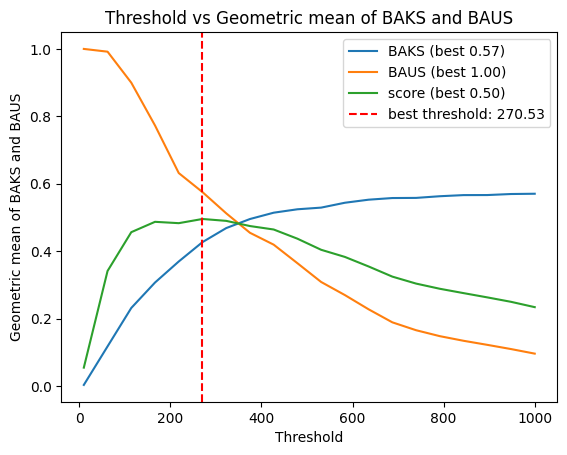

In [18]:
def plot_threshold_score(df, col="threshold"):
    best_score = df["score"].max()
    best_threshold = df[col][df["score"].idxmax()]

    # plot baus and baks
    plt.plot(
        df[col],
        df["baks"],
        label=f"BAKS (best {df['baks'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["baus"],
        label=f"BAUS (best {df['baus'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["score"],
        label=f"score (best {best_score:.2f})",
    )
    # line at the best threshold
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"best threshold: {best_threshold:.2f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Geometric mean of BAKS and BAUS")
    plt.title("Threshold vs Geometric mean of BAKS and BAUS")
    plt.legend()
    plt.show()


plot_threshold_score(base_threshold_df)

{'initial_threshold': np.float32(452.6313), 'mad': np.float32(310.36237)}

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


,threshold,baks,baus,score,k
0,-478.455811,0.000000,1.000000,0.000000,-3.000000
1,-459.645970,0.000000,1.000000,0.000000,-2.939394
2,-440.836130,0.000000,1.000000,0.000000,-2.878788
3,-422.026290,0.000000,1.000000,0.000000,-2.818182
4,-403.216449,0.000000,1.000000,0.000000,-2.757576
...,...,...,...,...,...
95,1308.479022,0.570264,0.014997,0.092479,2.757576
96,1327.288863,0.570264,0.012553,0.084609,2.818182
97,1346.098703,0.570264,0.011892,0.082350,2.878788
98,1364.908543,0.570264,0.010182,0.076198,2.939394


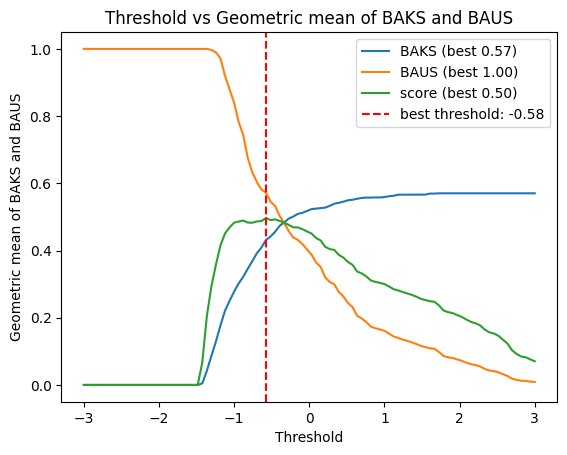

In [19]:
# keeping some old numbers when we compared train to test
# initial_threshold = 583.8616943359375
# mad = 180.09857177734375
# best k = -1.18 -> 371
# afterwards when we just look at the train set
# initial_threshold = 531.76
# mad = 165.7
# best k = -0.94

initial_threshold = np.median(distances)
mad = np.median(np.abs(distances - initial_threshold))
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
    }
)
k = np.linspace(-3, 3, 100)
mad_threshold_df = search_threshold(
    train_df, val_df, initial_threshold + (np.linspace(-3, 3, 100) * mad)
)
# add k as a column
mad_threshold_df["k"] = k
display(mad_threshold_df)
plot_threshold_score(mad_threshold_df, col="k")

In [20]:
# at the highest score, get the value of k
# this basically runs the test against our best validation hyperparameters
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
threshold = initial_threshold + (mad * best_k)
display(
    {
        "best_k": best_k,
        "mad": mad,
        "threshold": threshold,
        "val_baks": mad_threshold_df["baks"].max(),
        "val_baus": mad_threshold_df["baus"].max(),
        "val_score": mad_threshold_df["score"].max(),
    }
)
identity_other_only = sorted(
    set(test_df.identity.unique()) - set(train_df.identity.unique())
)
predictions = make_prediction(train_df, test_df, threshold)
baks = BAKS(test_df["identity"].values, predictions, identity_other_only)
baus = BAUS(
    test_df["identity"].values, predictions, identity_other_only, "new_individual"
)
# geometric average
score = np.sqrt(baks * baus)
display(
    {
        "test_baks": baks,
        "test_baus": baus,
        "test_score": score,
    }
)

{'best_k': np.float64(-0.5757575757575757),
 'mad': np.float32(310.36237),
 'threshold': np.float64(273.9378033262311),
 'val_baks': np.float64(0.5702644233602071),
 'val_baus': np.float64(0.9999999999999989),
 'val_score': np.float64(0.49659189782686497)}

{'test_baks': np.float64(0.41987985721648696),
 'test_baus': np.float64(0.5719811158758785),
 'test_score': np.float64(0.4900646378433061)}

In [21]:
# retune on the test set to get a new best threshold and see if
# this improves the score
new_train_df = pd.concat([train_df, val_df])
distances = get_min_distance_to_neighbor(new_train_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)
new_threshold_df = search_threshold(
    new_train_df, test_df, initial_threshold + (np.linspace(-3, 3, 100) * mad)
)

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


In [22]:
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
threshold = initial_threshold + (mad * best_k)
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": threshold,
    }
)
identity_other_only = sorted(
    set(test_df.identity.unique()) - set(new_train_df.identity.unique())
)
predictions = make_prediction(new_train_df, test_df, threshold)
baks = BAKS(test_df["identity"].values, predictions, identity_other_only)
baus = BAUS(
    test_df["identity"].values, predictions, identity_other_only, "new_individual"
)
# geometric average
score = np.sqrt(baks * baus)
display(
    {
        "test_baks": baks,
        "test_baus": baus,
        "test_score": score,
    }
)
# this is the best score we can get with this method

{'initial_threshold': np.float32(459.12988),
 'mad': np.float32(309.8407),
 'best_k': np.float64(-0.5757575757575757),
 'threshold': np.float64(280.7367535215436)}

{'test_baks': np.float64(0.4715383647532963),
 'test_baus': np.float64(0.5609892150322161),
 'test_score': np.float64(0.5143227946538307)}

Looks like the score increases if we include more items in the training dataset. This intuitively makes sense because we have more distances to look at.

# final prediction

In [23]:
# now for the final prediction
known_df = pdf[pdf.identity.notnull()]
unknown_df = pdf[pdf.identity.isnull()]

distances = get_min_distance_to_neighbor(known_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)
best_k = -0.9393939393939394
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": initial_threshold + (mad * best_k),
    }
)
# we already know from our validation set that we should use k=-1.182

predictions = make_prediction(known_df, unknown_df, initial_threshold + (mad * best_k))
# count how many are predicted as "unknown"
display(
    {
        "unknown": len(predictions[predictions == "new_individual"]),
        "known": len(predictions[predictions != "new_individual"]),
        "total": len(predictions),
    }
)

100%|██████████| 13074/13074 [03:36<00:00, 60.27it/s] 


{'initial_threshold': np.float32(372.645),
 'mad': np.float32(261.46594),
 'best_k': -0.9393939393939394,
 'threshold': np.float32(127.02547)}

{'unknown': 957, 'known': 1178, 'total': 2135}

In [24]:
# save this result
unknown_df["identity"] = predictions
output_path = (
    Path.home() / "shared/animalclef/data/predictions/20250425-megadescriptor-l-384.csv"
)
output_path.parent.mkdir(parents=True, exist_ok=True)
unknown_df[["image_id", "identity"]].to_csv(output_path, index=False, header=True)

/tmp/ipykernel_252432/3600044714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df["identity"] = predictions


## salamanders only

,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,107,226,226,0,0,100.0,0.0,0.0,107,0
1,Validation,121,197,0,197,0,0.0,100.0,0.0,107,14
2,Test,165,459,0,0,459,0.0,0.0,100.0,107,58


100%|██████████| 100/100 [00:03<00:00, 25.48it/s]


,threshold,baks,baus,score,k
0,75.501083,0.082555,1.000000,0.287323,-3.000000
1,77.368266,0.082555,1.000000,0.287323,-2.939394
2,79.235449,0.082555,1.000000,0.287323,-2.878788
3,81.102632,0.082555,1.000000,0.287323,-2.818182
4,82.969815,0.082555,1.000000,0.287323,-2.757576
...,...,...,...,...,...
95,252.883457,0.185358,0.107823,0.141372,2.757576
96,254.750639,0.185358,0.107823,0.141372,2.818182
97,256.617822,0.185358,0.095918,0.133339,2.878788
98,258.485005,0.185358,0.095918,0.133339,2.939394


{'initial_threshold': np.float32(167.92664),
 'mad': np.float32(30.808517),
 'best_k': np.float64(-1.7272727272727273),
 'threshold': np.float64(114.7119237726385)}

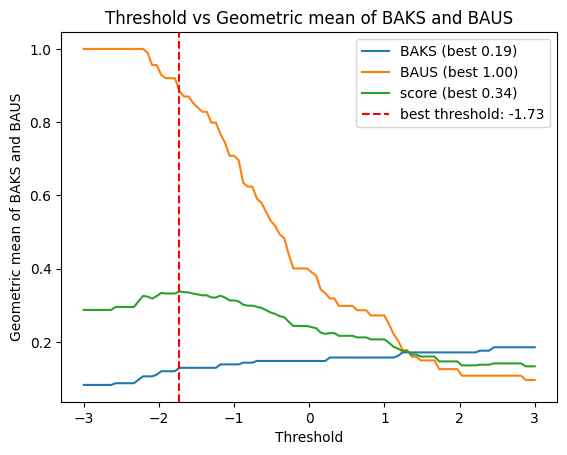

In [25]:
# what happens if we limit this just to salamanders?
# we have to tune again

cond = (
    (~pdf.identity.isnull())
    & (pdf.identity_count > 2)
    & (pdf.dataset == "SalamanderID2025")
)
train_df, val_df, test_df = split_reid_data(pdf[cond])
display(summarize_split(train_df, val_df, test_df))

distances = get_min_distance_to_neighbor(train_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)

# now find the best threshold for k
mad_threshold_df = search_threshold(
    train_df, val_df, initial_threshold + (np.linspace(-3, 3, 100) * mad)
)
# add k as a column
mad_threshold_df["k"] = np.linspace(-3, 3, 100)
display(mad_threshold_df)
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
threshold = initial_threshold + (mad * best_k)
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": threshold,
    }
)

plot_threshold_score(mad_threshold_df, col="k")

In [26]:
# now for the final prediction
known_df = pdf[pdf.identity.notnull() & (pdf.dataset == "SalamanderID2025")]
unknown_df = pdf[pdf.identity.isnull()]

distances = get_min_distance_to_neighbor(known_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)
best_k = best_k
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": initial_threshold + (mad * best_k),
    }
)
# we already know from our validation set that we should use k=-1.182

predictions = make_prediction(known_df, unknown_df, initial_threshold + (mad * best_k))
# count how many are predicted as "unknown"
display(
    {
        "unknown": len(predictions[predictions == "new_individual"]),
        "known": len(predictions[predictions != "new_individual"]),
        "total": len(predictions),
    }
)

100%|██████████| 1388/1388 [00:06<00:00, 221.91it/s]


{'initial_threshold': np.float32(144.88077),
 'mad': np.float32(29.508224),
 'best_k': np.float64(-1.7272727272727273),
 'threshold': np.float64(93.91201643510298)}

{'unknown': 1996, 'known': 139, 'total': 2135}

In [27]:
# write this result
output_path = (
    Path.home()
    / "shared/animalclef/data/predictions/20250425-megadescriptor-l-384-salamanders.csv"
)
output_path.parent.mkdir(parents=True, exist_ok=True)
unknown_df["identity"] = predictions
unknown_df[["image_id", "identity"]].to_csv(output_path, index=False, header=True)

/tmp/ipykernel_252432/1108673860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df["identity"] = predictions


In [39]:
! kaggle competitions submit -c animal-clef-2025 -f {output_path} -m "baseline salamanders only"

100%|███████████████████████████████████████| 42.9k/42.9k [00:00<00:00, 144kB/s]
Successfully submitted to AnimalCLEF25 @ CVPR-FGVC & LifeCLEF